In [14]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import collections
import itertools
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

In [2]:
!mkdir -p data
with ZipFile('digit-recognizer.zip', 'r') as zipObj:
   zipObj.extractall('data')

In [3]:
test_data = pd.read_csv('./data/test.csv')
train_data = pd.read_csv('./data/train.csv')

<BarContainer object of 10 artists>

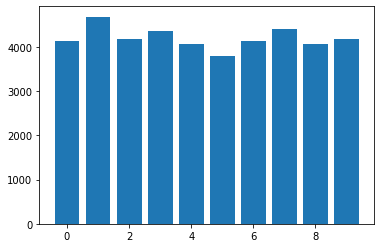

In [4]:
labels = train_data.label.values
train_labels = to_categorical(labels, num_classes = 10)
label_count = collections.Counter(labels)
plt.bar(label_count.keys(), label_count.values())

In [5]:
train_data.drop(columns={'label'}, inplace=True)
train_data /= 255.
test_data /= 255.

In [6]:
test_images = np.reshape(test_data.values, (test_data.shape[0],28,28,1))
train_images = np.reshape(train_data.values, (train_data.shape[0],28,28,1))
test_images[0].shape

(28, 28, 1)

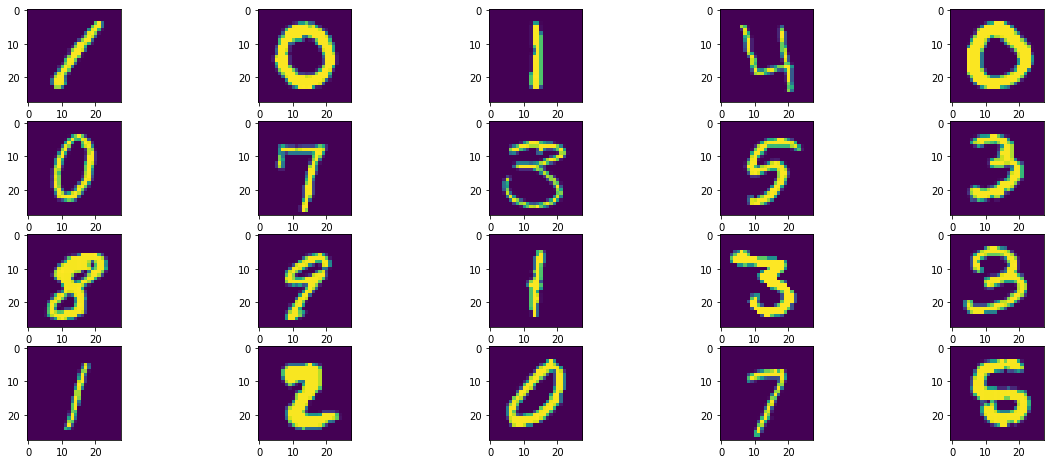

In [7]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(train_images[:20]):
    plt.subplot(len(train_images[:20]) / columns + 1, columns, i + 1)
    plt.imshow(image[:,:,0])

In [8]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size = 0.25, random_state=4)

In [9]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    return model 

In [10]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)         

In [11]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
 
# train the model
print("[INFO] training model...")
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=32, callbacks=[reduce_lr])

[INFO] training model...
Train on 31500 samples, validate on 10500 samples
Epoch 1/10
31500/31500 [==============================] - 67s 2ms/step - loss: 0.3508 - accuracy: 0.8871 - val_loss: 0.0819 - val_accuracy: 0.9764
Epoch 2/10
31500/31500 [==============================] - 67s 2ms/step - loss: 0.0989 - accuracy: 0.9713 - val_loss: 0.0756 - val_accuracy: 0.9786
Epoch 3/10
31500/31500 [==============================] - 72s 2ms/step - loss: 0.0776 - accuracy: 0.9786 - val_loss: 0.0466 - val_accuracy: 0.9872
Epoch 4/10
31500/31500 [==============================] - 69s 2ms/step - loss: 0.0611 - accuracy: 0.9831 - val_loss: 0.0589 - val_accuracy: 0.9860
Epoch 5/10
31500/31500 [==============================] - 68s 2ms/step - loss: 0.0553 - accuracy: 0.9850 - val_loss: 0.0373 - val_accuracy: 0.9898
Epoch 6/10
31500/31500 [==============================] - 72s 2ms/step - loss: 0.0443 - accuracy: 0.9873 - val_loss: 0.0615 - val_accuracy: 0.9860
Epoch 7/10
31500/31500 [===================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


<Figure size 1440x360 with 0 Axes>

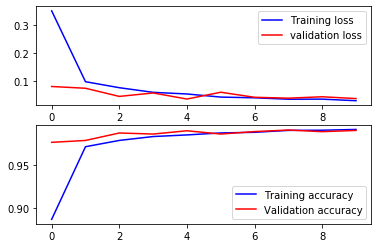

In [12]:
print(history.history.keys())
# Plot the loss and accuracy curves for training and validation 
plt.figure(figsize=(20,5))
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].legend()

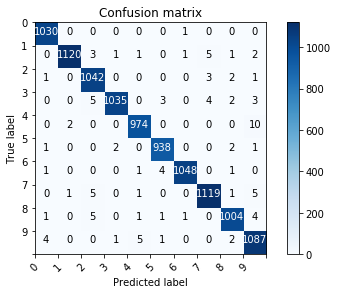

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(-0.5, len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))